In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib widget

# Implementing Dynamic Programming

## Example: The Double Integrator

![Double Integrator](https://underactuated.csail.mit.edu/figures/double_integrator_brick.svg)

In [2]:
granularity = 0.1

# State space: (x, x_dot), where x between -max_x and max_x and x_dot between -max_x_dot and max_x_dot
max_x = 3.0
X = np.arange(-max_x, max_x+granularity, granularity)
max_x_dot = 4.0
X_dot = np.arange(-max_x_dot, max_x_dot+1, granularity)
# XX, XX_dot = np.meshgrid(X, X_dot)
S = np.zeros((len(X), len(X_dot)))

# Action space: torque, where torque between -max_torque and max_torque
max_torque = 1
A = np.arange(-max_torque, max_torque+granularity, granularity)

# Goal state = [0, 0], i.e. stop (x_dot=0) at the origin (x=0)
s_goal = [0, 0]
is_goal = lambda s: np.array_equal(s, s_goal)

In [3]:
# Transition function: f(s, a)
delta_t = 0.01
def f(x, x_dot, a):
    x_dot += np.round(a*delta_t)
    x += np.round(x_dot*delta_t + 0.5*a*delta_t*delta_t)
    return x, x_dot

# Cost function: g(s, a) = minimum time to reach the goal state
def g(s, a):
    return 1 

In [4]:
def convert_idx_to_xxdot(idx):
    return (idx[0]*granularity - max_x, idx[1]*granularity - max_x_dot)

def convert_xxdot_to_idx(x, x_dot):
    return (int((x + max_x)/granularity), int((x_dot + max_x_dot)/granularity))

def xxdot_in_bounds(x, x_dot):
    return -max_x <= x < max_x and -max_x_dot <= x_dot < max_x_dot

In [ ]:
T = max(S.shape)
    
for t in tqdm(range(T)):
    S_copy = np.copy(S)
    for idx, s in np.ndenumerate(S_copy):
        x, x_dot = convert_idx_to_xxdot(idx)
        if is_goal(idx):
            continue

        S[idx] = min([g((x, x_dot), a) + S_copy[convert_xxdot_to_idx(*f(x, x_dot, a))] for a in A if xxdot_in_bounds(*f(x, x_dot, a))], default=0)

    if np.array_equal(S, S_copy):
        print("Converged at t = ", t)
        break  

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
c = ax.pcolormesh(S)
fig.colorbar(c, ax=ax)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

XX, YY = np.meshgrid(X, X_dot)
print(X.shape, X_dot.shape, S.shape)
print(XX.shape, YY.shape, S.shape)

ax.plot_surface(XX, YY, S.T, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('x_dot')
ax.set_zlabel('Cost-to-go')
plt.show()

## The Double Integrator: 2nd Try

In [10]:
q = np.linspace(-3.0, 3.0, 31)
qdot = np.linspace(-4.0, 4.0, 51)
state_grid = [set(q), set(qdot)]
dt = 0.1

input_grid = set(np.linspace(-1.0, 1.0, 9))

[Q, Qdot] = np.meshgrid(q, qdot, indexing='ij')

In [25]:
A = np.array([[0, 1], [0, 0]])
B = np.array([0, 1])

# The linear system is defined as: x_dot = A*x + B*u, where
#    x = [q, q_dot], u = [torque], x_dot = [q_dot, q_ddot]
# Simplifying the linear system we get: 
#    q_dot = q_dot
#    q_ddot = torque
def f(x, u):
    # return x[0] + x[1]*dt - 0.5*u*dt*dt , x[1] + u*dt
    return x[1], u

# The cost function is 1 (minimum time to reach the goal state)
def is_goal(x):
    return np.array_equal(x, np.array([0, 0]))

def g(x, u):
    return 1 if not is_goal(x) else 0

def find_nearest_idx(array, value):
    return (np.abs(array - value)).argmin()

def convert_state_to_nearest_idx(x):
    return (find_nearest_idx(q, x[0]), find_nearest_idx(qdot, x[1]))

In [26]:
J = np.zeros(Q.shape)
policy = np.zeros(Q.shape)

In [27]:
for i in range(max(Q.shape)):
    J_copy = np.copy(J)
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            min_cost = np.inf
            
            for u in input_grid:
                x = f([Q[i, j], Qdot[i, j]], u)
                idx = convert_state_to_nearest_idx(x) 
                min_cost = min(min_cost, g([Q[i, j], Qdot[i, j]], u) + J_copy[idx])
                policy[i, j] = u

            J[i, j] = min_cost

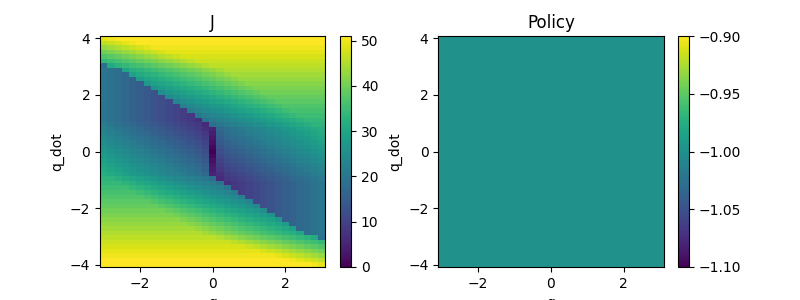

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
c = ax[0].pcolormesh(Q, Qdot, J, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('q')
ax[0].set_ylabel('q_dot')
ax[0].set_title('J')

c = ax[1].pcolormesh(Q, Qdot, policy, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('q')
ax[1].set_ylabel('q_dot')
ax[1].set_title('Policy')

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Q, Qdot, J, cmap='viridis')
ax.set_xlabel('q')
ax.set_ylabel('q_dot')
ax.set_zlabel('J')
plt.show()

# The General Case

In [27]:
def discrete_dp(S, A, f, g, s_goal, T=None):
    """
        This is an implementation of dynamic programming to solve control problems using discrete optimization. 
        It assumes finite state and action spaces.
        Inputs: 
            S -- discrete state space,
            A -- discrete action space,
            f:SxA --> S -- transition function, 
            g:SxA --> real -- cost function (to be minimized),
            s_goal -- goal state,
            T -- time horizon (default=max(S.shape))
    """
    # Initialize the value function
    if T is None:
        T = max(S.shape)

    cost_to_go = np.zeros(S.shape[0])
    policy = np.zeros(S.shape[0])

    # Iterate over time
    for t in range(T):
        cost_to_go_copy = np.copy(cost_to_go)
        # Iterate over states
        for i, s in enumerate(S): 
            # Compute the cost-to-go for each state-action pair
            cost_to_go[i] = min([g(s, a) + cost_to_go_copy[f(s, a)] for a in A])
            # Update the policy
            policy[i] = np.argmin([g(s, a) + cost_to_go_copy[f(s, a)] for a in A])
    
    return cost_to_go, policy
